### Section 2: The Factors

#### 1. Find mean, volatility, and Sharpe

In [2]:
# Import data
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
df = pd.read_excel('../data/factor_pricing_data.xlsx', sheet_name='factors (excess returns)')
df = df.set_index('Date')
df.tail()

,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
2022-04-30,-0.0946,-0.0040,0.0619,0.0363,0.0592,0.0489
2022-05-31,-0.0034,-0.0006,0.0841,0.0144,0.0398,0.0248
2022-06-30,-0.0843,0.0130,-0.0597,0.0185,-0.0470,0.0079
2022-07-31,0.0957,0.0187,-0.0410,0.0068,-0.0694,-0.0396
2022-08-31,-0.0378,0.0151,0.0031,-0.0480,0.0131,0.0209


In [3]:
def portfolio_stats(data):
    # Calculate the mean and annualize
    mean = data.mean() * 12

    # Volatility = standard deviation
    # Annualize the result with sqrt(12)
    vol = data.std() * np.sqrt(12)

    # Sharpe Ratio is mean / vol
    sharpe_ratio = mean / vol
    
    # VaR
    var = data.quantile(0.05)

    # Format for easy reading
    return round(pd.DataFrame(data = [mean, vol, sharpe_ratio, var], 
        index = ['Mean', 'Volatility', 'Sharpe', 'VaR (0.05)']), 4)

display(portfolio_stats(df))

,MKT,SMB,HML,RMW,CMA,UMD
Mean,0.0831,0.0122,0.0275,0.0448,0.0333,0.0655
Volatility,0.1567,0.1005,0.1088,0.0834,0.0715,0.1545
Sharpe,0.5305,0.1211,0.2529,0.5376,0.4652,0.4241
VaR (0.05),-0.0741,-0.0419,-0.0419,-0.0285,-0.0267,-0.0681


#### 2. a) Does each factor have positive risk premium?

Yes, all 6 factors have mean > 0, though the Market shows the highest premium of > 8%, while the size factor has the lowest returns of just 1.22%

#### 2. b) How have the factors performed since the time of the case (2015 - Present)?

In [4]:
print("2015 - Present")
presentData = df.copy().loc['2015':]
display(portfolio_stats(presentData))

2015 - Present


,MKT,SMB,HML,RMW,CMA,UMD
Mean,0.1069,-0.0058,-0.0197,0.0395,0.0022,0.0255
Volatility,0.1602,0.0977,0.1325,0.0712,0.0796,0.1368
Sharpe,0.6676,-0.0590,-0.1488,0.5553,0.0282,0.1865
VaR (0.05),-0.0788,-0.0419,-0.0482,-0.0233,-0.0267,-0.0644


We can see based on the means above that the market has done very well since the time of the case, with excess returns of ~10%, while the rest of the factors have actually decreased their excess returns, with the Size and Value factors actually having negative excess returns.

#### 3. a) Report the correlation matrix accross the six factors. Does the construction method succeed in keeping correlations small?

Sample Correlations


<AxesSubplot: >

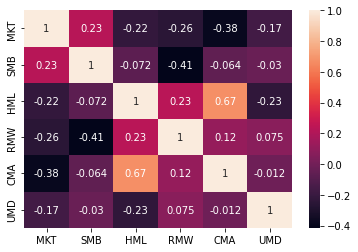

In [5]:
corrmat = df.corr()
print("Sample Correlations")
display(sns.heatmap(corrmat,annot=True))

Yes, the construction method appears to keep correlations small. Most of the correlations are actually negative, and the larges positive correlation we have is only 0.67.

#### 3. b) Fama and French say that HML is somewhat redundant in their 5-factor model. Does this seem to be the case?

I would argue that HML does seem to be redundant. It has overall fairly low means, and it's correlation with CMA is 0.67, the highest correlation in the sample. The additional complexity of having this as a factor does not seem to be justified.

#### 4. Report the tangency weights for a portfolio with these 6 assets. 

In [6]:
def tangency_weights(returns,dropna=True,scale_cov=1):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()

    return pd.DataFrame(weights, index=returns.columns,columns=['tangency weights'])

display(tangency_weights(df))

,tangency weights
MKT,0.201062
SMB,0.081551
HML,-0.047037
RMW,0.288377
CMA,0.377449
UMD,0.098597


#### 4. a) Which factors seem most important? And least?

The size (SMB) and value (HML) factors seem to be the least important, as they have the lowest weights in the tangency portfolio. The investment (CMA) and profitability (RMW) seem to be most important, with high weights in the tangency portfolio.

#### 4. b) Are the factors with low mean returns still useful?

Yes. CMA and RMW both had mean returns of 0.2% and 3.9%, yet make up the majority of the tangency portfolio. Their importance likely comes from their low correlation with the other assets in the portfolio.

#### 4. c) Re-do the tangency portfolio, but this time only include MKT, SMB, HML, and UMD. What factors get high/low tangency weights now?

In [7]:
smaller_dataset = df.drop(columns=['CMA', 'RMW'])
display(tangency_weights(smaller_dataset))

,tangency weights
MKT,0.331433
SMB,0.006051
HML,0.362221
UMD,0.300295


After re-computing the tangency portfolio, we can see that the market, value, and momentum factors are all given roughly equal weight (between 30 and 37 percent), while the size factor is given barely any weight at all, with 0.6%.

#### What do you conclude about the importance or unimportance of these styles?

It seems like size and value may be less effective in the factor model when the other factors are present. The profitability and investment factors seem more important, though overall the correlations are pretty small for all factors. The additional complexity added by including the size and value factors may not be worth it.


### Section 3: Testing Modern LPMs

In [8]:
portfolio_data = pd.read_excel('../data/factor_pricing_data.xlsx', sheet_name='portfolios (excess returns)')
portfolio_data = portfolio_data.set_index('Date')
portfolio_data.tail()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-30,-0.0015,0.0259,0.0421,0.0302,0.0636,-0.1375,-0.2785,-0.1087,0.0203,-0.0701,...,-0.0394,-0.1094,-0.0215,-0.1142,-0.0548,-0.0854,-0.0336,-0.1156,-0.1269,-0.0780
2022-05-31,0.0726,-0.0329,-0.0025,-0.0163,0.0264,-0.0088,-0.0353,-0.0698,-0.0515,-0.0648,...,-0.0460,-0.0462,0.0100,-0.0567,-0.0332,0.0338,0.0111,-0.0237,0.0392,-0.0147
2022-06-30,-0.1251,-0.0197,0.0040,-0.0008,-0.1169,-0.1302,-0.1093,-0.1243,-0.0262,-0.1206,...,-0.0850,-0.0720,-0.0649,-0.0856,-0.0908,-0.1245,-0.0211,-0.1366,-0.0985,-0.1273
2022-07-31,0.0630,0.0360,0.0320,0.0541,0.0048,0.0555,0.1696,0.1200,0.0068,0.1178,...,0.0701,0.0925,0.0900,0.1625,0.1181,0.0846,0.0307,0.1402,0.1036,0.0993
2022-08-31,0.0504,-0.0065,-0.0459,-0.0206,-0.0031,-0.0596,-0.0245,-0.0519,-0.0235,-0.0620,...,-0.0930,-0.0165,-0.0179,-0.0365,-0.0166,-0.0360,-0.0103,-0.0631,-0.0121,-0.0422


In [12]:
CAPM =  ['MKT']
FF_3F = ['MKT','SMB','HML']
FF_5F = ['MKT','SMB','HML','RMW','CMA']
AQR = ['MKT','HML','RMW','UMD']

# df - the portfolio excess returns data
# factor_df - the factor excess returns data
# factors - a list of factors we're testing (ex: AQR = ['MKT', 'HML', 'RMW', 'UMD'])
# test - label for test (ex: 'AQR')
def time_series_test(df, factor_df, factors, test, annualization=12):
    res = pd.DataFrame(data = None, index = df.columns, columns = [test + ' alpha', test + ' R-squared'])
    
    for port in df.columns:
        y = df[port]
        X = sm.add_constant(factor_df[factors])
        model = sm.OLS(y, X).fit()
        res.loc[port] = [model.params[0] * annualization, model.rsquared]
    
    return res

#### 1. a) For each regression, report the estimated alpha and r-squared.

In [14]:
AQR_test = time_series_test(portfolio_data, df, AQR, 'AQR')
display(AQR_test)

,AQR alpha,AQR R-squared
Agric,0.015617,0.330166
Food,0.015205,0.468121
Soda,0.023801,0.309781
Beer,0.026757,0.424796
Smoke,0.039908,0.257474
Toys,-0.027704,0.503276
Fun,0.027091,0.615578
Books,-0.029218,0.688613
Hshld,-0.00089,0.568142
Clths,-0.001364,0.618474


#### 1. b) Calculate the mean absolute error of the estimated alphas. If the pricing model worked, should these alpha estimates be large or small? Why? Based on your MAE stat, does this seem to support the pricing model or not?

In [15]:
print('AQR MAE: ' + str(round(AQR_test['AQR alpha'].abs().mean(), 4)))

AQR MAE: 0.0235


If the pricing model worked, we would expect the alphas to be very low (0 in fact). By the definition of the factor model, all returns from the portfolio should be explained by the factors in the regression, which would cause alpha to equal zero. The mean absolute error of the alpha seems a bit high (2.35%), given we were expecting a value very close to zero. This seems to imply the pricing model is a good, but not great, fit to the portfolio.

#### 2. Test the CAPM, FF 3-Factor Model, and the FF 5-Factor Model. Report the MAE statistic for each of these models and compare it with the AQR Model MAE. Which model fits best?

In [20]:
CAPM_test = time_series_test(portfolio_data, df, CAPM, 'CAPM')
print('CAPM MAE: ' + str(round(CAPM_test['CAPM alpha'].abs().mean(), 4)))
display(CAPM_test)

CAPM MAE: 0.0215


,CAPM alpha,CAPM R-squared
Agric,0.027558,0.323423
Food,0.054032,0.364266
Soda,0.051889,0.253812
Beer,0.067282,0.336213
Smoke,0.08212,0.180856
Toys,-0.027049,0.491605
Fun,0.004875,0.600021
Books,-0.014594,0.654171
Hshld,0.02505,0.507258
Clths,0.013873,0.557288


In [19]:
FF_3F_test = time_series_test(portfolio_data, df, FF_3F, 'FF_3F')
print('French-Fama 3 Factor MAE: ' + str(round(FF_3F_test['FF_3F alpha'].abs().mean(), 4)))
display(FF_3F_test)

French-Fama 3 Factor MAE: 0.0254


,FF_3F alpha,FF_3F R-squared
Agric,0.022531,0.346552
Food,0.045295,0.416249
Soda,0.039306,0.280149
Beer,0.064901,0.366306
Smoke,0.069518,0.222621
Toys,-0.028883,0.518101
Fun,0.001779,0.61647
Books,-0.027857,0.69395
Hshld,0.023208,0.522483
Clths,0.006687,0.569914


In [22]:
FF_5F_test = time_series_test(portfolio_data, df, FF_5F, 'FF_5F')
print('French-Fama 5 Factor MAE: ' + str(round(FF_5F_test['FF_5F alpha'].abs().mean(), 4)))
display(FF_5F_test)


French-Fama 5 Factor MAE: 0.0325


,FF_5F alpha,FF_5F R-squared
Agric,0.008669,0.350883
Food,0.004724,0.493345
Soda,0.001595,0.312767
Beer,0.018097,0.447034
Smoke,0.01124,0.291025
Toys,-0.060395,0.540097
Fun,0.013509,0.620897
Books,-0.046454,0.706463
Hshld,-0.015172,0.589292
Clths,-0.020975,0.627444


According to the calculated values above, CAPM fits best, with the lowest MAE of 0.0215.

#### 3. Does any particular factor seem especially important or unimportant for pricing? Do you think Fama and French should use Momentum Factor?

The Market factor seems particularly important, as the CAPM had the lowest MAE and all of the models include it. Momentum does seem to also be an important factor, as including it in the AQR model generates a lower MAE than either of the French Fama models.

#### 4. This does not matter for pricing, but report the average of the time-series regression r-squared statistics. Do this for each of the three models you tested. Do these models lead to high time-series r-squared stats? That is, would these factors be good in a Linear Factor Decomposition of the assets?

In [23]:
factor_tests = CAPM_test.join(FF_3F_test).join(FF_5F_test).join(AQR_test)

factors_r2 = factor_tests[['CAPM R-squared', 'FF_3F R-squared', 'FF_5F R-squared', 'AQR R-squared']].mean().to_frame('R-Squared')

display(factors_r2)

,R-Squared
CAPM R-squared,0.527498
FF_3F R-squared,0.571061
FF_5F R-squared,0.596360
AQR R-squared,0.575712


These factors do not lead to high R-squared values, so we would not want to use them in a Linear Factor Decomposition of the assets.

#### 5. We tested these models using the time-series tests. Re-test using the cross-sectional test.

In [32]:
# Generates the betas from the regression on the factors
def ts_betas(df, factor_df, factors, intercept=False):
    if intercept == True:
        res = pd.DataFrame(data = None, index = df.columns, columns = ['alpha'])
        res[factors] = None
    else:
        res = pd.DataFrame(data = None, index = df.columns, columns = factors)
    
    for port in df.columns:
        y = df[port]
        if intercept == True:
            X = sm.add_constant(factor_df[factors])
        else:
            X = factor_df[factors]
        model = sm.OLS(y, X).fit()
        res.loc[port] = model.params
    
    return res

# This method runs a cross-sectional test for a portfolio given portfolio excess returns, factor excess returns, and the factors you want to include
def cross_section(df, factor_df, factors, ts_int=True, annualization=12):
    betas = ts_betas(df, factor_df, factors, intercept=ts_int)
    res = pd.DataFrame(data = None, index = betas.index, columns = factors)
    res['Predicted'] = None
    res['Actual'] = None
    
    for port in res.index:
        res.loc[port, factors] = betas.loc[port]
        prem = (betas.loc[port] * factor_df[factors]).sum(axis=1).mean() * annualization
        res.loc[port,['Predicted','Actual']] = prem, df[port].mean() * annualization
    
    return res

def cross_premia(df_cs, factors):
    y = df_cs['Actual'].astype(float)
    X = df_cs[factors].astype(float)

    return sm.OLS(y,X).fit().params.to_frame('CS Premia')

def cross_premia_mae(df_cs, factors, model):
    y = df_cs['Actual'].astype(float)
    X = df_cs[factors].astype(float)

    print(model + ' MAE: ' + str(round(sm.OLS(y,X).fit().resid.abs().mean(), 4)))
    

In [26]:
CAPM_cs = cross_section(portfolio_data, df, CAPM, ts_int=True)
FF_3F_cs = cross_section(portfolio_data, df, FF_3F, ts_int=True)
FF_5F_cs = cross_section(portfolio_data, df, FF_5F, ts_int=True)
AQR_cs = cross_section(portfolio_data, df, AQR, ts_int=True)

AQR_cs.head()

,MKT,HML,RMW,UMD,Predicted,Actual
Agric,0.820943,0.155745,-0.022301,0.087183,0.077238,0.092855
Food,0.682631,0.163392,0.525506,0.034443,0.087063,0.102267
Soda,0.791106,0.20735,0.488692,-0.097353,0.087004,0.110805
Beer,0.727232,0.012689,0.604952,0.076292,0.092927,0.119684
Smoke,0.722708,0.211976,0.656358,-0.040284,0.092704,0.132612


#### a) Report the time-series premia of the factors (just their sample averages) and compare to the cross-sectionally estimated premia of the factors. Do they differ substantially?

In [27]:
(df.mean()*12).to_frame('TS Premia')

,TS Premia
MKT,0.083123
SMB,0.012169
HML,0.027523
RMW,0.044845
CMA,0.033260
UMD,0.065513


In [29]:
print("The French-Fama 3 Factor cross premia")
display(cross_premia(FF_3F_cs, FF_3F))

print("The French-Fama 5 Factor cross premia")
display(cross_premia(FF_5F_cs, FF_5F))

print("The CAPM cross premia")
display(cross_premia(CAPM_cs, CAPM))

print("The AQR cross premia")
display(cross_premia(AQR_cs, AQR))

The French-Fama 3 Factor cross premia


,CS Premia
MKT,0.101003
SMB,-0.065920
HML,-0.017297


The French-Fama 5 Factor cross premia


,CS Premia
MKT,0.094775
SMB,-0.058725
HML,-0.035406
RMW,0.036789
CMA,-0.015450


The CAPM cross premia


,CS Premia
MKT,0.084943


The AQR cross premia


,CS Premia
MKT,0.086563
HML,-0.040885
RMW,0.045500
UMD,0.055284


We find that the MKT factor is very close to it's sample average across all portfolios, and that RMW and UMD are also fairly close. However the other factors vary quite a bit from their sample averages.

#### 5. b) Report the MAE of the cross-sectional regression residuals for each of the four models, (the v^i). How do they compare to to the MAE of the time-series alphas?

In [37]:
print("CAPM Cross-Sectional MAE")
cross_premia_mae(CAPM_cs, CAPM, 'CAPM')
print("French-Fama 3 Factor Cross-Sectional MAE")
cross_premia_mae(FF_3F_cs, FF_3F, 'FF_3F')
print("French-Fama 5 Factor Cross-Sectional MAE")
cross_premia_mae(FF_5F_cs, FF_5F, 'FF_5F')
print("AQR Cross-Sectional MAE")
cross_premia_mae(AQR_cs, AQR, 'AQR')

print()
print("CAPM Time Series MAE: 0.0215")
print('French-Fama 3 Factor Time Series MAE: 0.0254')
print('French-Fama 5 Factor Time Series MAE: 0.0325')
print('AQR Time Series MAE: 0.0235')

CAPM Cross-Sectional MAE
CAPM MAE: 0.0214
French-Fama 3 Factor Cross-Sectional MAE
FF_3F MAE: 0.0161
French-Fama 5 Factor Cross-Sectional MAE
FF_5F MAE: 0.0136
AQR Cross-Sectional MAE
AQR MAE: 0.0172

CAPM Time Series MAE: 0.0215
French-Fama 3 Factor Time Series MAE: 0.0254
French-Fama 5 Factor Time Series MAE: 0.0325
AQR Time Series MAE: 0.0235


We find that the MAE of CAPM is very similar from the Cross-Sectional to Time-Series regression, but that the Cross-Sectional test generates a lower MAE for the other three models compared to the Time Series.